### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from cartopy.io import shapereader

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models

In [3]:
# pip uninstall ewatercycle-HBV -y 

In [4]:
# pip install ewatercycle-HBV==1.7.0

In [5]:
# pip install --upgrade git+https://github.com/Daafip/ewatercycle-HBV@dev

In [6]:
# pip uninstall HBV -y 

In [7]:
# pip install --upgrade git+https://github.com/Daafip/HBV-bmi@dev

In [8]:
# for local mode
from typing import Type
from ewatercycle.base.model import LocalModel
from ewatercycle_HBV.model import HBVMethods # Use custom forcing instead
from HBV import HBV as HBV_bmi
from bmipy import Bmi

class LocalModelHBV(LocalModel, HBVMethods):
    """The HBV eWaterCycle model, with the local BMI."""
    bmi_class: Type[Bmi] = HBV_bmi

In [9]:
LocalModelHBV

__main__.LocalModelHBV

#### set up paths

In [10]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [11]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [12]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
HRU_id = 2479155
alpha = 1.2626

In [13]:
from ewatercycle_HBV.forcing import HBVForcing

In [14]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'test_forcing.txt',
                          test_data_bool=True
                          )

#### Can also run locally when developing - v0.1.1. here
```py
from ewatercycle.container import ContainerImage
LeakyBucket(forcing=forcing, bmi_image=ContainerImage("local_image:latest"))
```

In [15]:
from ewatercycle.container import ContainerImage
local_model = LocalModelHBV(forcing=test_forcing)

need to  add a local container to run

In [16]:
config_file, _ = local_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [17]:
local_model.initialize(config_file)

In [18]:
ds = xr.open_dataset(forcing_path / local_model.forcing.pr)

In [19]:
Q_m = []
time = []
snow = []
while local_model.time < local_model.end_time:
    local_model.update()
    Q_m.append(local_model.get_value("Q"))
    snow.append(local_model.get_value("Sp"))
    time.append(local_model.time_as_datetime.date())

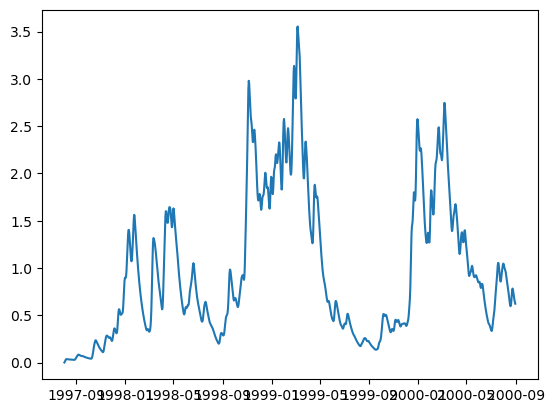

In [20]:
plt.plot(time, Q_m)

In [21]:
local_model.finalize()

In [22]:
print(local_model)

parameter_set=None forcing=HBVForcing(start_time='1997-08-01T00:00:00Z', end_time='2000-08-31T00:00:00Z', directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing'), shape=None, filenames={}, camels_file='test_forcing.txt', pr='HBV_forcing_test_2024-04-10 15_21.nc', evspsblpot='HBV_forcing_test_2024-04-10 15_21.nc', tas='HBV_forcing_test_2024-04-10 15_21.nc', alpha=1.26, test_data_bool=True)


Test camels

In [23]:
from ewatercycle.forcing import sources

In [24]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2005-09-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

In [25]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

In [26]:
observations_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Observations')

In [27]:
local_model_camels = LocalModelHBV(forcing=camels_forcing)

In [28]:
config_file, _ = local_model_camels.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [29]:
local_model_camels.initialize(config_file)

In [30]:
ds_camels = xr.open_dataset(forcing_path / local_model_camels.forcing.pr)

In [31]:
Q_m = []
time = []
snow = []
while local_model_camels.time < local_model_camels.end_time:
    local_model_camels.update()
    Q_m.append(local_model_camels.get_value("Q"))
    snow.append(local_model_camels.get_value("Sp"))
    time.append(local_model_camels.time_as_datetime.date())

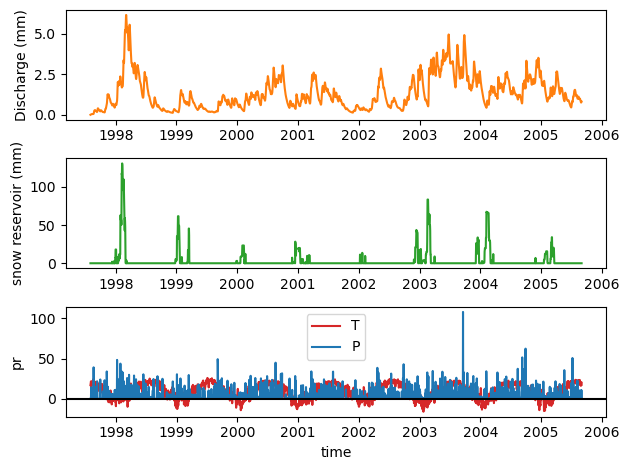

In [32]:
fig, ax = plt.subplots(3,1)
ax[0].plot(time, Q_m, color="C1")
ax[0].set_ylabel("Discharge (mm)")
ax[1].set_ylabel("snow reservoir (mm)")
ax[1].plot(time, snow, color="C2")

ds_camels['tas'].plot(color="C3",ax=ax[2],label="T")
ds_camels['pr'].plot(color="C0",ax=ax[2],label="P")
ax[2].axhline(0,color='k')
ax[2].legend()

fig.tight_layout()

# makkink

In [33]:
#shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"
shapeFile = forcing_path/ "Rhine_shp" / "Rhine.shp"

#location to saved forcing results from previous notebook
forcingLocation = forcing_path / "RhineForcing2000-2002"

#GRDC station ID for the observation station
grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"
observation_path = path / "Observations"

#period of interest. Make sure that GRDC data is available for this period and that.
experiment_start_time="2000-01-01T00:00:00Z"
experiment_end_time="2002-12-31T00:00:00Z"


In [34]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)

In [35]:
local_model_era5 = LocalModelHBV(forcing=ERA5_forcing)

In [36]:
config_file, _ = local_model_era5.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [37]:
local_model_era5.initialize(config_file)

In [38]:
ds_pr_era5_adj = xr.open_dataset(local_model_era5._config['mean_temperature_file'])

In [39]:
ds_pr_era5 = xr.open_dataset(ERA5_forcing.directory / ERA5_forcing.filenames['pr'])
ds_pr_era5['pr'] =  ds_pr_era5['pr']*86400

In [40]:
ds_tas_era5 = xr.open_dataset(ERA5_forcing.directory / ERA5_forcing.filenames['tas'])
# ds_tas_era5['tas'] = ds_tas_era5['tas'] -273.15

In [41]:
ds_tas_era5['tas'].mean().values > 200

True

In [42]:
Q_m = []
time = []
snow = []
while local_model_era5.time < local_model_era5.end_time:
    local_model_era5.update()
    Q_m.append(local_model_era5.get_value("Q"))
    snow.append(local_model_era5.get_value("Sp"))
    time.append(local_model_era5.time_as_datetime.date())

In [43]:
Q_obs = pd.read_feather(observation_path / f'{grdc_station_id}_Q_Day.feather')
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["SUB_AREA"] * 1e6
Q_obs['streamflow'] = Q_obs['streamflow'] / shape_area * (1000 * 86400)

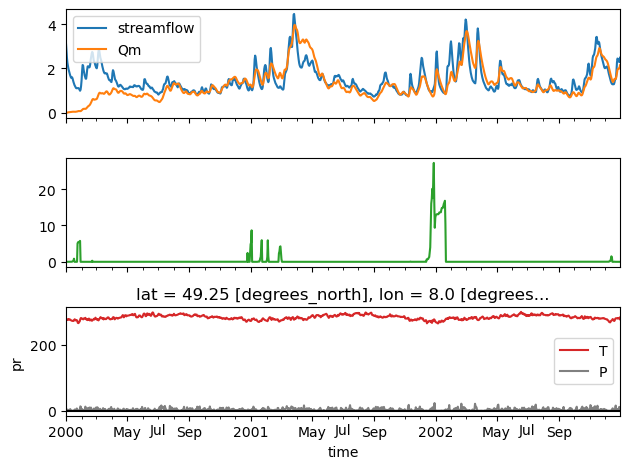

In [44]:
fig, ax = plt.subplots(3,1,sharex=True)
Q_obs.plot(ax=ax[0])
ax[0].plot(time, Q_m, color="C1",label="Qm")
ax[0].legend()

ax[1].plot(time, snow, color="C2", label="Snow reservoir")


ds_tas_era5['tas'].plot(color="C3",ax=ax[2],label="T")
ds_pr_era5['pr'].plot(color="grey",ax=ax[2],label="P")
ax[2].axhline(0,color='k')
ax[2].legend()
fig.tight_layout()

## Lumped caravan

In [45]:
HRU_id = 1022500

In [46]:
caravan_forcing = sources['LumpedCaravanForcing'].retrieve(start_time = experiment_start_date,
                                                          end_time = experiment_end_date,
                                                          directory = forcing_path / "Camels",
                                                          basin_id = f"camels_0{HRU_id}",
                                                          )

In [47]:
local_caravan_model = LocalModelHBV(forcing=caravan_forcing)

In [48]:
config_file, _ = local_caravan_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [49]:
caravan_forcing.filenames['pr']

'camels_01022500_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_pr.nc'

In [50]:
local_caravan_model.initialize(config_file)

In [59]:
ds_caravan_tas = xr.open_dataset(forcing_path / local_caravan_model.forcing['tas'])
ds_caravan_pr = xr.open_dataset(forcing_path / local_caravan_model.forcing['pr'])

In [54]:
Q_m = []
time = []
snow = []
while local_caravan_model.time < local_caravan_model.end_time:
    local_caravan_model.update()
    Q_m.append(local_caravan_model.get_value("Q"))
    snow.append(local_caravan_model.get_value("Sp"))
    time.append(local_caravan_model.time_as_datetime.date())

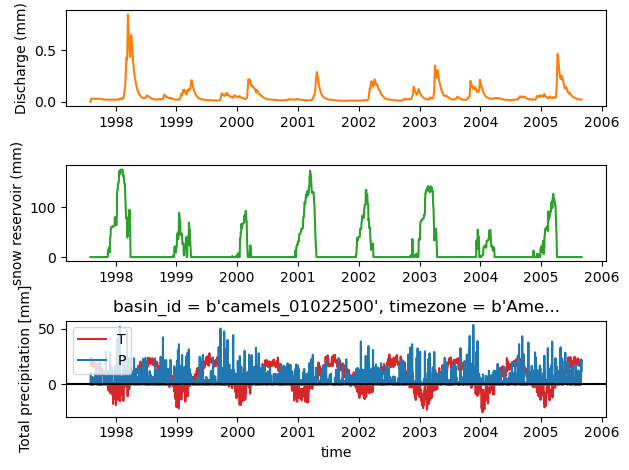

In [60]:
fig, ax = plt.subplots(3,1)
ax[0].plot(time, Q_m, color="C1")
ax[0].set_ylabel("Discharge (mm)")
ax[1].set_ylabel("snow reservoir (mm)")
ax[1].plot(time, snow, color="C2")

ds_caravan_tas['tas'].plot(color="C3",ax=ax[2],label="T")
ds_caravan_pr['pr'].plot(color="C0",ax=ax[2],label="P")
ax[2].axhline(0,color='k')
ax[2].legend()

fig.tight_layout()

# Containerised

In [86]:
from ewatercycle.models import HBV

In [76]:
model = HBV(forcing=test_forcing)

In [77]:
config_file, _ = model.setup(
                parameters=','.join([str(p) for p in par_0]),
                initial_storage=','.join([str(s) for s in s_0]),
           )

In [78]:
model.initialize(config_file)

In [79]:
ds_container = xr.open_dataset(forcing_path / model.forcing.tas)

In [80]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [81]:
model.finalize()

In [82]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

In [83]:
Q_m_in_ref = np.loadtxt(r"Observations/Q_m_out_ref.txt")

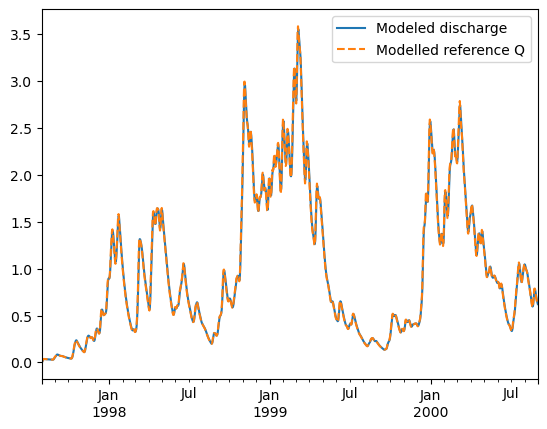

In [85]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.plot(df.index, Q_m_in_ref[:-1],ls="--",label="Modelled reference Q");
# ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=-1,label="Observations")
ax.legend(bbox_to_anchor=(1,1))

## Containerised HBV caravan

In [88]:
caravan_forcing = sources['LumpedCaravanForcing'].retrieve(start_time = experiment_start_date,
                                                          end_time = experiment_end_date,
                                                          directory = forcing_path / "Camels",
                                                          basin_id = f"camels_0{HRU_id}",
                                                          )

In [89]:
caravan_model = HBV(forcing=caravan_forcing)

In [90]:
config_file, _ = caravan_model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [91]:
caravan_model.initialize(config_file)

In [92]:
ds_camels = caravan_forcing.to_xarray()

In [93]:
ds_camels

<xarray.Dataset> Size: 95kB
Dimensions:         (time: 2954)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 24kB 1997-08-01 ... 2005-09-01
    basin_id        |S64 64B b'camels_01022500'
    timezone        |S64 64B b'America/New_York'
    name            |S64 64B b'Narraguagus River at Cherryfield, Maine'
    country         |S64 64B b'United States of America'
    lat             float64 8B 44.8
    ...              ...
    moisture_index  float64 8B -0.7161
    seasonality     float64 8B 0.4585
    high_prec_freq  float64 8B 0.05668
    high_prec_dur   float64 8B 1.084
    low_prec_freq   float64 8B 0.6388
    low_prec_dur    float64 8B 3.238
Data variables:
    Q               (time) float32 12kB ...
    evspsblpot      (time) float32 12kB ...
    pr              (time) float32 12kB ...
    tas             (time) float32 12kB ...
    tasmax          (time) float32 12kB ...
    tasmin          (time) float32 12kB ...

In [94]:
Q_m = []
time = []
snow = []
while caravan_model.time < caravan_model.end_time:
    caravan_model.update()
    Q_m.append(caravan_model.get_value("Q"))
    snow.append(caravan_model.get_value("Sp"))
    time.append(caravan_model.time_as_datetime.date())

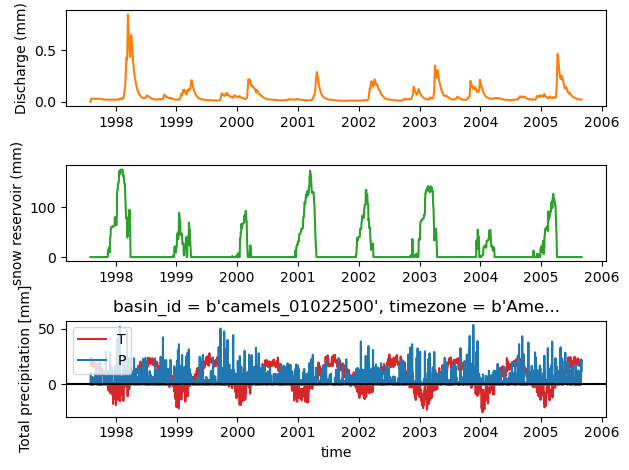

In [95]:
fig, ax = plt.subplots(3,1)
ax[0].plot(time, Q_m, color="C1")
ax[0].set_ylabel("Discharge (mm)")
ax[1].set_ylabel("snow reservoir (mm)")
ax[1].plot(time, snow, color="C2")

ds_camels['tas'].plot(color="C3",ax=ax[2],label="T")
ds_camels['pr'].plot(color="C0",ax=ax[2],label="P")
ax[2].axhline(0,color='k')
ax[2].legend()

fig.tight_layout()